In [1]:
from tab_model import TabNetRegressor, TabModel
import torch
import numpy as np
import time
from tqdm import tqdm

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

featcols = np.load(f"{featloc}/x_name.npy")
targcols = np.load(f"{targloc}/y_name.npy")
targcols

array(['ccn_001', 'ccn_003', 'ccn_006', 'CHI', 'CHI_CCN', 'D_ALPHA',
       'D_GAMMA', 'D_ALPHA_CCN', 'D_GAMMA_CCN', 'PM25'], dtype='<U11')

In [3]:
from sklearn.model_selection import train_test_split

nsnapshots = 133

np.random.seed(52)
full_indx = np.arange(nsnapshots)
train_idx, val_idx = train_test_split(full_indx, test_size=0.2, train_size=0.8) 

data_source = 'kedar'

In [4]:
def getting_datapaths(
    train_idx,
    val_idx,
    files='sunny', 
    target_cols=["ccn_001", "ccn_003", "ccn_006"],
    exclude_cols = ["XLONG", "XLAT"],
):
    # getting colname
    featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
    targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

    featcols = np.load(f"{featloc}/x_name.npy")
    targcols = np.load(f"{targloc}/y_name.npy")
    
    target_idx = [np.where(targcols == i)[0].item() for i in target_cols ]
    feat_idx   = [np.where(featcols == i)[0].item() for i in featcols if i not in exclude_cols]
    
    # getting paths
    if files == 'sunny':
        # my data
        featloc = "/home/kwoksun2/hackathon_data/norm_data"
        targloc = "/home/kwoksun2/hackathon_data/norm_data"

        train_feat_files = [f"{featloc}/t{t}_feat.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/t{t}_feat.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/t{t}_targ.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/t{t}_targ.npy" for t in val_idx]
    
    elif files == 'kedar':
        featloc = "/home/kwoksun2/hackathon_data/norm_data_timesteps_feat"
        targloc = "/home/kwoksun2/hackathon_data/norm_data_timesteps_targ"

        train_feat_files = [f"{featloc}/{t}feat_norm.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/{t}feat_norm.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/{t}targ_norm.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/{t}targ_norm.npy" for t in val_idx]

    return [np.array(train_feat_files),np.array(train_targ_files)], [np.array(val_feat_files),np.array(val_targ_files)], feat_idx, target_idx

def prepare_dataloaders(feat_files, targ_files, feat_idx, target_idx, box_fraction=0.1, shuffle=True):
    NBOX = 39 * 159 * 169
    
    num_samples_per_box = int(NBOX * box_fraction)
    
    d = []
    t = []
    for f_fn, t_fn in zip(feat_files, targ_files):
        # select a fraction of data randomly
        sidx = np.random.randint(0, NBOX, num_samples_per_box)
        feats = np.load(f_fn)
        targs = np.load(t_fn)
        
        if targs.ndim == 1:
            targs = targs.reshape(10,-1).transpose()

        # keep the subset
        d.append(feats[sidx][:,feat_idx])
        t.append(targs[sidx][:,target_idx])
    train_feat, train_targ = np.vstack(d), np.vstack(t)

    tds = torch.utils.data.TensorDataset(
        torch.from_numpy(train_feat).float(), 
        torch.from_numpy(train_targ).float()
    )
    return torch.utils.data.DataLoader(tds, batch_size=1024, shuffle=shuffle)

In [5]:
targcols

array(['ccn_001', 'ccn_003', 'ccn_006', 'CHI', 'CHI_CCN', 'D_ALPHA',
       'D_GAMMA', 'D_ALPHA_CCN', 'D_GAMMA_CCN', 'PM25'], dtype='<U11')

In [6]:
target_cols=["ccn_001", "ccn_003", "ccn_006"]

# target_cols=['CHI', 'CHI_CCN'] 

target_cols = ['D_ALPHA',
       'D_GAMMA', 'D_ALPHA_CCN', 'D_GAMMA_CCN']

exclude_cols = ["XLONG", "XLAT"]
train_files, val_files, feat_idx, target_idx = getting_datapaths(
    train_idx, 
    val_idx, 
    files=data_source,
    target_cols=target_cols,
    exclude_cols=exclude_cols
)

In [7]:
train_feat_files, train_targ_files = train_files
val_feat_files,   val_targ_files   = val_files

In [8]:
clf = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

/home/kwoksun2/hackathon_data/tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [9]:
clf._set_network()
clf._update_network_params()



In [10]:
lambda_sparse = 0.001

In [11]:
def loss_fn(ypred, y):
    return ((ypred-y)**2).mean()
def train_step(dl, model, optim):
    tstart = time.time()
    total_loss = 0
    count = 0
    for X, y in tqdm(dl):
        model.train()

        optim.zero_grad()
        
        ypred, M_loss = model(X.cuda())
        loss  = loss_fn(ypred, y.cuda())
        loss  = loss - lambda_sparse * M_loss
        loss.backward()
        optim.step()
        
        total_loss += loss.item()

    return total_loss/ len(dl), time.time() - tstart

@torch.no_grad()
def val_step(dl, model):
    tstart = time.time()
    total_loss = 0
    for X, y in tqdm(dl):
        model.eval()
        
        ypred, M_loss = model(X.cuda())
        loss  = loss_fn(ypred, y.cuda())
        loss  = loss - lambda_sparse * M_loss

        total_loss += loss.item()
    return total_loss/ len(dl) , time.time() - tstart


In [12]:
net = clf.network
optim = torch.optim.Adam(net.parameters())

In [13]:
train_feat_files, train_targ_files = train_files
val_feat_files,   val_targ_files   = val_files

nchunks = 20

# per chunk 133/20 ~ 6
max_grp_size = 5
nchunks_train = len(train_feat_files) // max_grp_size
nchunks_val   = len(val_feat_files) // max_grp_size

idx_shuf = np.arange(len(train_feat_files))

train_hist = []
val_hist   = []

for i in range(5,20):
    np.random.shuffle(idx_shuf)

    train_feat_grps= np.array_split(train_feat_files[idx_shuf], nchunks_train)
    train_targ_grps= np.array_split(train_targ_files[idx_shuf], nchunks_train)

    val_feat_grps= np.array_split(val_feat_files, nchunks_val)
    val_targ_grps= np.array_split(val_targ_files, nchunks_val)

    total_train_loss = 0
    total_val_loss   = 0
    total_train_time = 0
    total_val_time   = 0

    for feat_fns, targs_fns in zip(train_feat_grps, train_targ_grps):
        tdl = prepare_dataloaders(feat_fns, targs_fns, feat_idx, target_idx, shuffle=True)
        train_loss, train_time = train_step(tdl, net, optim)
        total_train_loss += train_loss/ len(train_feat_grps)


    for feat_fns, targs_fns in zip(val_feat_grps, val_targ_grps):
        tdl = prepare_dataloaders(feat_fns, targs_fns, feat_idx, target_idx, shuffle=False)
        val_loss, val_time = val_step(tdl, net)
        total_val_loss += val_loss/ len(val_feat_grps)
        
    train_hist.append(total_train_loss)
    val_hist.append(total_val_loss)
    print(total_train_loss, total_val_loss)
        
    # checkpoint data
    checkpoint = {}
    checkpoint['model_state_dict'] = net
    checkpoint['epoch'] = i
    checkpoint['datasource'] = data_source  
    checkpoint['exclude_cols'] = exclude_cols
    checkpoint['target_cols'] = target_cols
    checkpoint['total_train_loss'] = total_train_loss
    checkpoint['total_val_loss'] = total_val_loss

    torch.save(checkpoint, f"ep_{i}_{data_source}_{','.join(target_cols)}_{','.join(exclude_cols)}_tabnet.pt")

100%|██████████| 512/512 [00:17<00:00, 28.92it/s]


0.3968521799655908 0.10783527018428057


100%|██████████| 512/512 [00:16<00:00, 31.29it/s]


0.07807131972926959 0.04364275236916444


100%|██████████| 512/512 [00:16<00:00, 30.79it/s]


0.04734695222610772 0.039868545316287966


100%|██████████| 512/512 [00:17<00:00, 29.63it/s]


0.03712063707417362 0.029248726854632742


100%|██████████| 512/512 [00:20<00:00, 25.17it/s]


0.031509759813726494 0.023596151662188085


100%|██████████| 512/512 [00:27<00:00, 18.49it/s]


0.028908435175623113 0.023362986346466816


100%|██████████| 512/512 [00:27<00:00, 18.91it/s]


0.027027555117861566 0.01877245630560693


100%|██████████| 512/512 [00:17<00:00, 28.85it/s]


0.02558415357788599 0.01852921292019797


100%|██████████| 512/512 [00:17<00:00, 29.52it/s]


0.024443139386451342 0.019398845739223607


100%|██████████| 512/512 [00:17<00:00, 29.08it/s]


0.024877961817614463 0.024691576491985744


100%|██████████| 512/512 [00:16<00:00, 30.95it/s]


0.023946362597823068 0.015113145968632117


100%|██████████| 512/512 [00:15<00:00, 33.78it/s]


0.02252099807398404 0.012496215400648162


100%|██████████| 512/512 [00:14<00:00, 35.20it/s]


0.019637999270421473 0.012012330170923003


100%|██████████| 512/512 [00:15<00:00, 34.12it/s]


0.018333131398650157 0.012141288979991945


100%|██████████| 512/512 [00:22<00:00, 23.20it/s]

0.017421018676409564 0.010479757872734755


In [46]:
explain_matrix, masks = clf.explain(X[:100])

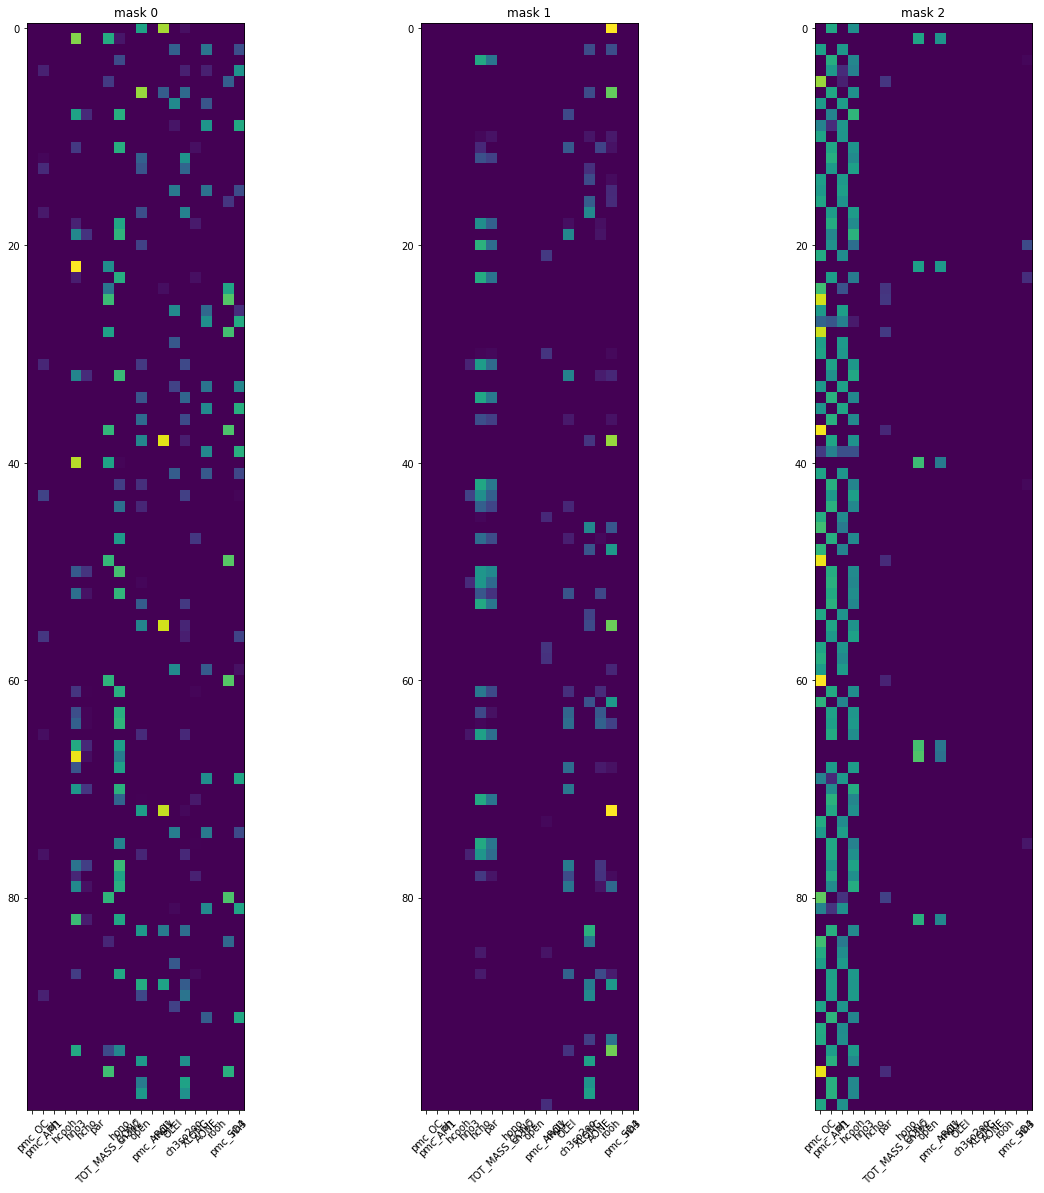

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:500, ix[:20]], vmin=0.001)
    axs[i].set_xticks(range(20))
    axs[i].set_xticklabels(np.array(feat_cols)[ix[:20]],rotation=90)
    axs[i].set_title(f"mask {i}")

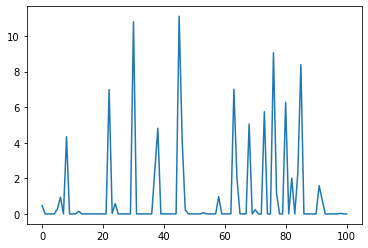

In [53]:
plt.plot(masks[1].sum(0))